In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
from typing import List
import time
from IPython import display

import pandas as pd
from qiskit.quantum_info import SparsePauliOp
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import ParameterVector
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms import QAOA
from qiskit_optimization.applications import Maxcut
from qiskit_aer import AerSimulator
from qiskit.primitives import BackendSampler  # Use V1 Sampler for compatibility




m = 5  # layers
A = np.zeros([m+2,100])
B = np.zeros([m+2,100])

# Extracted optimized parameters from another 10 node graph using p=5 layers and fully optimized
initial_parameters = [np.float64(1.6633964825024572), np.float64(0.950425279390121), np.float64(1.7245949514104175), np.float64(1.4454812516742008), np.float64(1.5324263167909598), np.float64(0.7618322215343744), np.float64(-0.5772299610164958), np.float64(-0.558880616225206), np.float64(1.3165318785714761), np.float64(0.18576975817077163)]

for ii in range(100):
    A[0][ii] = ii+1
    B[0][ii] = ii+1
    n = 15  # nodes
    G= nx.erdos_renyi_graph(n,0.5)

    for (u, v) in G.edges():
        G[u][v]['weight'] = random.uniform(1.0, 1.0)

    w = np.zeros([n,n])
    for i in range(n):
        for j in range(n):
            temp = G.get_edge_data(i,j,default=0)
            if temp != 0:
                w[i][j] = temp["weight"]

    quadratic_program = Maxcut(w).to_quadratic_program()
    
    

    # Use QAOA
    for jj in range(m):
        # Set the optimizer to optimize only the specific layer
        k = jj # layer to be optimized
        num_layers_to_optimize = 1
        initial_parameters[k] = np.random.rand() * np.pi  # Random initial parameter for the (k+1)^th layer
        initial_parameters[k + m] = np.random.rand() * np.pi  # Random initial parameter for the (k+1)^th layer
        # Initialize backend and sampler
        backend = AerSimulator()
        sampler = BackendSampler(backend)  # V1 interface
        # Gradient free optimizer method program
        optimizer = COBYLA()  # Gradient free optimizer
        qaoa = QAOA(optimizer=optimizer, reps=m, initial_point=initial_parameters, sampler=sampler)
        # Get the operator and offset
        op, offset = quadratic_program.to_ising()

        # Run the QAOA algorithm
        qaoa_result = qaoa.compute_minimum_eigenvalue(op)
        eigenstate = qaoa_result.eigenstate

        # Extract the most likely state
        sorted_counts = sorted(eigenstate.items(), key=lambda x: x[1], reverse=True)
        most_likely_state = sorted_counts[0][0]  # Get the bitstring with the highest probability
        #print("Most likely state (bitstring):", most_likely_state)

        # Convert the bitstring into a binary array
        solution = np.array([int(bit) for bit in reversed(list(bin(most_likely_state)[2:].zfill(n)))])

        # Print the solution
        cut_edges = [(i, j) for i, j in G.edges if solution[i] != solution[j]]

        A[jj+1][ii] = len(cut_edges)
        
        #classical program
    sol = 0
    for b in range(2**n):
        x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
        Cut_value = 0
        for i in range(n):
            for j in range(n):
                Cut_value += w[i][j]*x[i]*(1-x[j])
        if sol < Cut_value:
            sol = Cut_value
            xlist = x
    
    A[m+1][ii] = int(sol)
    B[m+1][ii] = int(sol)





C:\Users\shubh\AppData\Local\Temp\ipykernel_15284\4232538283.py:58: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler = BackendSampler(backend)  # V1 interface
C:\Users\shubh\AppData\Local\Temp\ipykernel_15284\4232538283.py:58: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler = BackendSampler(backend)  # V1 interface
C:\Users\shubh\AppData\Local\T

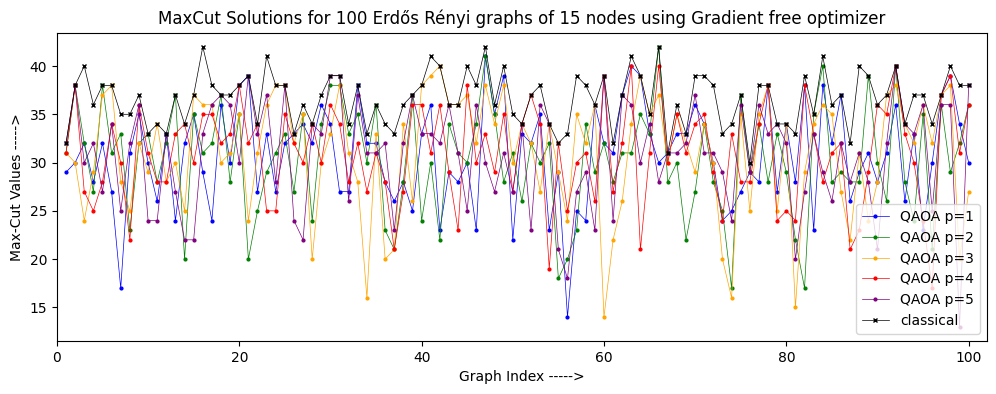

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))  # Width: 12 inches, Height: 4 inches
plt.xlim(0,102)
plt.plot(A[0], A[1], label='QAOA p=1', marker='o', markersize=2, linewidth=0.5, color='blue') 
plt.plot(A[0], A[2], label='QAOA p=2', marker='o', markersize=2, linewidth=0.5, color='green')
plt.plot(A[0], A[3], label='QAOA p=3', marker='o', markersize=2, linewidth=0.5, color='orange')
plt.plot(A[0], A[4], label='QAOA p=4', marker='o', markersize=2, linewidth=0.5, color='red')
plt.plot(A[0], A[5], label='QAOA p=5', marker='o', markersize=2, linewidth=0.5, color='purple')
plt.plot(A[0], A[6], label='classical', marker='x', markersize=3, linewidth=0.5, color='black')
 

#plt.grid()
plt.xlabel("Graph Index ----->")
plt.ylabel("Max-Cut Values ----->")
plt.title("MaxCut Solutions for 100 Erdős Rényi graphs of 15 nodes using Gradient free optimizer")
plt.legend(loc='best')

Gradient free normalized maxcut values w.r.t. classical method:  [0.8417535269029781, 0.827835059580888, 0.8478315289424979, 0.8458167366534807, 0.843082329565627]


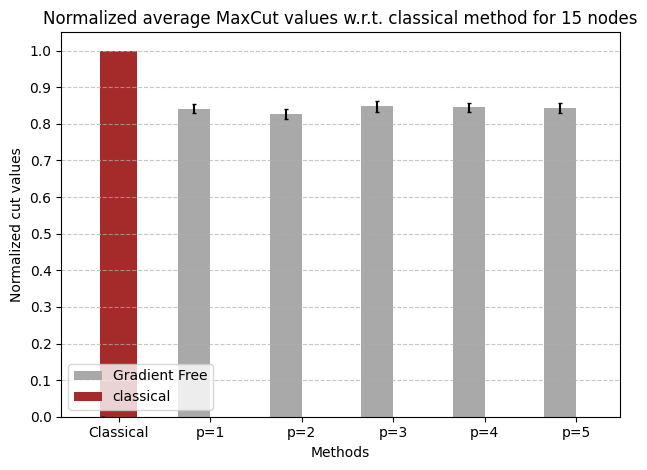

In [3]:
C = [0.]
CC = np.zeros([5,100])
C_err =[0.]
for j in range(0,5,1):
    s = 0
    for i in range(0,100,1):
        ss = A[j+1][i]/A[6][i]
        s += ss
        CC[j][i] = ss
    s = s/100
    
    C.append(float(s)) 
    
    mean = np.mean(CC[j])
    std_dev = np.std(CC[j], ddof=1)
    sem = std_dev/np.sqrt(len(CC[j]))
    C_err.append(float(sem))

print('Gradient free normalized maxcut values w.r.t. classical method: ',C[1:])
#print('Gradient based normalized maxcut values w.r.t. classical method: ',D[1:])
E = ['Classical','p=1','p=2','p=3','p=4','p=5']
bar_width = 0.35  # Width of each bar
x_indices = np.arange(len(E))  # Indices for groups
cl = [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]  # for classical method

plt.bar(x_indices - bar_width/2, C, bar_width,yerr=C_err,capsize=1.5, label='Gradient Free',color='darkgray') 
plt.bar(x_indices,cl,width=0.4,color='brown',label='classical')

plt.title('Normalized average MaxCut values w.r.t. classical method for 15 nodes')
plt.xlabel("Methods")
plt.ylabel("Normalized cut values")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(x_indices, E)  # Set x-axis tick labels to `x`
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='lower left', fontsize=10)
plt.tight_layout()